In [1]:
import torch
import torch_geometric as pyg
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch_geometric as pyg
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from scipy.sparse.linalg import eigs, eigsh
import seaborn as sns
import dgl
from utils import *

/home/jamesl/anaconda3/envs/pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def SBM_Prob_Matrix(data:Data):
    edge_index = data.edge_index
    y = data.y
    Prob_Matrix = torch.zeros((data.num_classes, data.num_classes))
    for (node_1, node_2) in edge_index.T:
        Prob_Matrix[y[node_1]][y[node_2]] += 1
        Prob_Matrix[y[node_2]][y[node_1]] += 1
    Prob_Matrix = Prob_Matrix / data.num_edges
    return Prob_Matrix

In [7]:
dataset_name_ls = ['CoraGraphDataset', 'CiteseerGraphDataset', 'PubmedGraphDataset', 'TexasDataset', 'WisconsinDataset', 'CornellDataset', 'SquirrelDataset', 'ChameleonDataset']
SBM_Prob_dict = {}
for dataset_name in dataset_name_ls:
    dataset = dgl.data.__getattribute__(dataset_name)()
    data = convert_dgl_to_pyg(dataset)
    Prob_Matrix = SBM_Prob_Matrix(data)
    SBM_Prob_dict[dataset_name] = Prob_Matrix

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Done loading data from cached files.
Done loading data from cached files.
Done loading data from cached files.
Done loading data from cached files.
Done loading data from cached files.


In [8]:
SBM_Prob_dict

{'CoraGraphDataset': tensor([[2.0235e-01, 6.0629e-03, 4.3577e-03, 3.0504e-02, 1.6673e-02, 1.4210e-02,
          1.5157e-02],
         [6.0629e-03, 1.5498e-01, 1.1747e-02, 1.2694e-02, 3.7893e-03, 5.3050e-03,
          3.7893e-04],
         [4.3577e-03, 1.1747e-02, 3.1338e-01, 1.0042e-02, 3.7893e-04, 5.6840e-03,
          3.7893e-04],
         [3.0504e-02, 1.2694e-02, 1.0042e-02, 4.4524e-01, 2.5957e-02, 1.0231e-02,
          3.0315e-03],
         [1.6673e-02, 3.7893e-03, 3.7893e-04, 2.5957e-02, 2.5009e-01, 3.5998e-03,
          1.1368e-03],
         [1.4210e-02, 5.3050e-03, 5.6840e-03, 1.0231e-02, 3.5998e-03, 1.5801e-01,
          8.7154e-03],
         [1.5157e-02, 3.7893e-04, 3.7893e-04, 3.0315e-03, 1.1368e-03, 8.7154e-03,
          9.5870e-02]]),
 'CiteseerGraphDataset': tensor([[0.0453, 0.0241, 0.0100, 0.0145, 0.0202, 0.0046],
         [0.0241, 0.2003, 0.0516, 0.0130, 0.0171, 0.0061],
         [0.0100, 0.0516, 0.4538, 0.0390, 0.0102, 0.0139],
         [0.0145, 0.0130, 0.0390, 0.2833, 

In [2]:
data = Planetoid(root='data/Planetoid', name='PubMed')
data = data[0]
data.num_nodes

19717

In [5]:
data.x

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1046, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0194, 0.0080,  ..., 0.0000, 0.0000, 0.0000],
        [0.1078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0266, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [10]:
19717**3 / 2700**3 * 2 / 60

12.98105416656167

In [17]:
import torch
import torch_geometric.utils as pyg_utils

# Original edge indices
edge_index = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 0]], dtype=torch.long)

# Mask indicating which nodes to include in the subgraph
include_nodes = torch.tensor([False, False, True, True], dtype=torch.bool)

# Correctly extracting the subgraph
sub_edge_index, _ = pyg_utils.subgraph(include_nodes, edge_index, relabel_nodes=True)

# Create a new Data object for the subgraph
sub_data = pyg.data.Data(edge_index=sub_edge_index)


In [2]:
def homophily_score(data):
    X = data.x
    norm_x_ls = []
    norm_x_ls.append(torch.linalg.norm(X, ord=2, dim=1))
    normed_X = X / (norm_x_ls[-1].unsqueeze(1) + 1e-6)
    A = pyg.utils.to_dense_adj(data.edge_index).squeeze()
    H_score = torch.trace(A @ normed_X @ normed_X.T) / data.num_edges
    return H_score.item()

In [3]:
import networkx as nx
import numpy as np
import utils

dataset_name_ls = ['Cora', 'CiteSeer', 'PubMed']
for dataset_name in dataset_name_ls:
    source = Planetoid(root='../data', name=dataset_name)
    data = source[0]
    overall_random = utils.overall_random_graph(data)
    random_SBM, p_ls, q_ls = utils.random_SBM_graph(data)
    print(f"{dataset_name}: {homophily_score(data)}, random_SBM: {homophily_score(random_SBM)}, overall_random: {homophily_score(overall_random)}")
    print(f"p: {p_ls}\nq: {q_ls}")


Cora: 0.16765451431274414, random_SBM: 0.06422016769647598, overall_random: 0.05663285776972771
p: tensor([0.0174, 0.0349, 0.0190, 0.0070, 0.0146, 0.0188, 0.0314])
q: tensor([0.0034, 0.0031, 0.0034, 0.0046, 0.0035, 0.0033, 0.0031])
CiteSeer: 0.19063380360603333, random_SBM: 0.04877884313464165, overall_random: 0.04410294443368912
p: tensor([0.0056, 0.0052, 0.0093, 0.0051, 0.0078, 0.0068])
q: tensor([0.0019, 0.0022, 0.0020, 0.0023, 0.0021, 0.0021])
PubMed: 0.2718951106071472, random_SBM: 0.07406949996948242, overall_random: 0.07239408046007156
p: tensor([0.0012, 0.0010, 0.0010])
q: tensor([0.0006, 0.0008, 0.0008])


In [28]:
def homophily_score2(x, edge_index):
    norm_x_ls = []
    norm_x_ls.append(torch.linalg.norm(x, ord=2, dim=1))
    normed_X = x / (norm_x_ls[-1].unsqueeze(1) + 1e-6)
    A = pyg.utils.to_dense_adj(edge_index).squeeze()
    H_score = torch.trace(A @ normed_X @ normed_X.T) / edge_index.size(1)
    return H_score.item()

In [17]:
dataset_name_ls = ['Cora', 'CiteSeer', 'PubMed']
for dataset_name in dataset_name_ls:
    source = Planetoid(root='../data', name=dataset_name)
    data = source[0]
    print(dataset_name, ":", homophily_score(data))

Cora : 0.16765451431274414
CiteSeer : 0.19063380360603333
PubMed : 0.2718951106071472


In [3]:
dataset_name_ls = ['Cora', 'CiteSeer', 'PubMed']
norm_x_ls = []
for dataset_name in dataset_name_ls:
    source = Planetoid(root='../data', name=dataset_name)
    data = source[0]
    X = data.x
    y = data.y
    # Delta = y.unsqueeze(1) == y.unsqueeze(0)
    norm_x_ls.append(torch.linalg.norm(X, ord=2, dim=1))
    normed_X = X / (norm_x_ls[-1].unsqueeze(1) + 1e-6)
    # print(torch.allclose(torch.linalg.norm(normed_X, ord=2, dim=1), torch.ones(normed_X.size(0))))
    A = pyg.utils.to_dense_adj(data.edge_index).squeeze()
    H_score = torch.trace(A @ normed_X @ normed_X.T) / data.num_edges
    print(f'{dataset_name}: {H_score}')

Cora: 0.16765451431274414
CiteSeer: 0.19063380360603333
PubMed: 0.2718951106071472


Cora: max=5.4772257804870605, min=1.0, median=4.4721360206604
CiteSeer: max=7.348469257354736, min=0.0, median=5.656854152679443
PubMed: max=1.2907483577728271, min=0.20112761855125427, median=0.37067756056785583


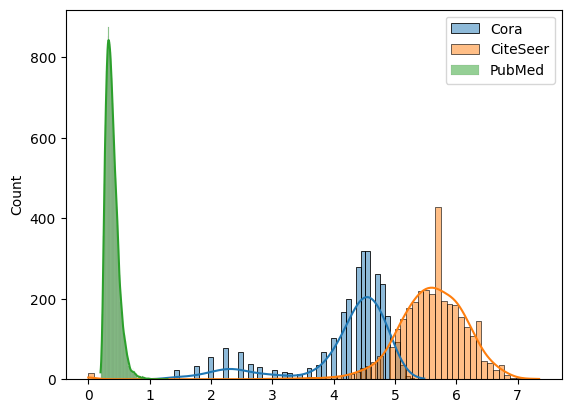

In [4]:
for dataset_name, norm_x in zip(dataset_name_ls, norm_x_ls):
    print(f'{dataset_name}: max={torch.max(norm_x)}, min={torch.min(norm_x)}, median={torch.median(norm_x)}')
    sns.histplot(norm_x, kde=True, label=dataset_name)
plt.legend()

In [8]:
A = torch.eye(3)
A[0, 1] = 1
torch.vstack(torch.where(A))

tensor([[0, 0, 1, 2],
        [0, 1, 1, 2]])

In [8]:
class GraphNodeSampler: # down sample graph according to leverage score, both threshold and number of excluded nodes are supported
    def __init__(self, data:torch_geometric.data.data.Data, threshold=0.2, num_excluded=100) -> None:
        self.data = data
        self.threshold = threshold
        self.num_excluded = num_excluded
        self.n = data.num_nodes
        self.leverage_score = self.compute_leverage_score()

    def compute_leverage_score(self, x=None):
        if x is None:
            x = self.data.x
        print("calculating hat matrix\n\n...\n")
        H = x @ torch.linalg.pinv(x.T @ x) @ x.T
        leverage_score = torch.diag(H)
        print("leverage_score computed")
        return leverage_score

    def get_idx_by_threshold(self, threshold=None):
        if threshold is None:
            threshold = self.threshold
        idx = torch.where(self.leverage_score < threshold)[0]
        print(f"{len(idx)}, {len(idx) / self.n * 100:.2f}% nodes are excluded")
        return idx
    
    def get_idx_by_num_excluded(self, num_excluded=None):
        if num_excluded is None:
            num_excluded = self.num_excluded
        return torch.topk(self.leverage_score, num_excluded, largest=False)[1]
    
    def sample(self, idx):
        full_size_idx = torch.ones(self.n, dtype=torch.bool)
        full_size_idx[idx] = False
        train_mask = self.data.train_mask & full_size_idx
        test_mask = self.data.test_mask & full_size_idx
        val_mask = self.data.val_mask & full_size_idx
        edge_index = pyg.utils.subgraph(idx, self.data.edge_index)[0]
        print(f"sampled training set size: {train_mask.sum()}, new test set size: {test_mask.sum()}, new val set size: {val_mask.sum()}")
        print(f"original: training set size: {self.data.train_mask.sum()}, original test set size: {self.data.test_mask.sum()}, original val set size: {self.data.val_mask.sum()}")
        print(f"percentage preserved: training set: {train_mask.sum() / self.data.train_mask.sum() * 100:.2f}%, test set: {test_mask.sum() / self.data.test_mask.sum() * 100:.2f}%, val set: {val_mask.sum() / self.data.val_mask.sum() * 100:.2f}%")
        return pyg.data.Data(x=self.data.x, edge_index=edge_index, y=self.data.y, train_mask=train_mask, test_mask=test_mask, val_mask=val_mask)

In [9]:
torch.tensor([True, False, True]) & torch.tensor([True, True, False])

tensor([ True, False, False])

In [10]:
class GConvModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GConvModel, self).__init__()
        self.conv1 = pyg.nn.GCNConv(input_dim, hidden_dim)
        self.conv2 = pyg.nn.GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [11]:
sampler = GraphNodeSampler(data, threshold=0.2)
idx = sampler.get_idx_by_threshold()
sampled_data = sampler.sample(idx)

calculating hat matrix

...



leverage_score computed
19717, 100.00% nodes are excluded
sampled training set size: 0, new test set size: 0, new val set size: 0
original: training set size: 60, original test set size: 1000, original val set size: 500
percentage preserved: training set: 0.00%, test set: 0.00%, val set: 0.00%


In [12]:
(sampled_data.train_mask).sum(), (sampled_data.test_mask).sum(), (sampled_data.val_mask).sum()

(tensor(0), tensor(0), tensor(0))

In [13]:
data.train_mask.sum()

tensor(60)